# Grover FoM Conditional Run Demo

We want to run a simple circuit (e.g., a Φ⁺ Bell state) **only if** the backend shows adequate Grover performance.
Grover FoM (GRADE) measures how well a device concentrates probability on marked states while penalizing dispersion and leaks to non-targets.

In this notebook we will:

1. **Define the Grover FoM** (choose number of targets (M), λ and μ; enforce **n ≥ 2** qubits).
2. **Set a score threshold** (e.g., `score > 0.2`) to decide if the backend is “good enough”.
3. **Pick a backend adapter** (Aer or IBM). not checked for IONQ and others.
4. **Configure a compliance check** that evaluates Grover and compares the score to the threshold.
5. **Run conditionally**: if the check **passes**, execute our target circuit (Φ⁺); otherwise run a fallback.
6. **Inspect metrics** (`P_T`, `σ_T`, `P_N`, `score`) and visualize basic results. Visualization can be seen in *Graph FoM*

> Benchmark note: to match literature conventions, keep **transpiler optimization offs** (`optimization_level=0`).


In [29]:
from qiskit import QuantumCircuit
from qiskit_ibm_runtime.fake_provider import FakeManilaV2, FakeTorino

from qonscious import run_conditionally
from qonscious.actions import QonsciousCallable
from qonscious.adapters import AerSamplerAdapter, IBMSamplerAdapter
from qonscious.checks import MeritComplianceCheck
from qonscious.foms import GroverFigureOfMerit

In [30]:
def phi_plus(): #build a sample circuit, can be any circuit
    qc = QuantumCircuit(2, 2)
    qc.h(0)
    qc.cx(0, 1)
    qc.measure([0, 1], [0, 1])
    return qc

In [31]:
from qonscious.adapters import BackendAdapter


def on_pass(backend_adapter : BackendAdapter, figureOfMeritResults):
    firstFoMResult = figureOfMeritResults[0]
    print("Grover FoM passed the compliance check!")
    print(f"Score: {firstFoMResult['properties']['score']:.3f}")
    print("Running our Phi+ circuit")
    run_result = backend_adapter.run(phi_plus(), shots=2048)
    print("Phi+ circuit finished running")
    return run_result

# Este seria el No Op en caso de fallo
fallback = QonsciousCallable(
    lambda adapter, fom_results, **kwargs: None,
)


In [32]:
#Mandatory Grover FoM variables
N_TARGETS = 2
L_FACTOR = 0
MU_FACTOR = 0
fom = GroverFigureOfMerit(
    num_targets=N_TARGETS,
    lambda_factor=L_FACTOR,
    mu_factor=MU_FACTOR,
    num_qubits=4,  # Optionally specify number of qubits to build the search space. If not provided 2 is the minimum.
    #targets_int=[0], # Targets can be specified manually eg. to search for '00000'
)

In [33]:
THRESHOLD = 0
def grade_score_over(threshold: float):
    """Función de utilidad para verificar el score GRADE en 'properties'."""
    # Retorna una función lambda que toma el resultado del FoM (r)
    return lambda r: r["properties"]["score"] > threshold

check_grover_is_ok = MeritComplianceCheck(
    figure_of_merit=fom,
    decision_function=lambda r: r["properties"]["score"] > THRESHOLD,
)


In [34]:
backend_adapter = AerSamplerAdapter()
#backend_adapter = IBMSamplerAdapter(FakeManilaV2()) # edit as needed
#backend_adapter = IBMSamplerAdapter(FakeTorino()) # edit as needed

qonscious_result = run_conditionally(
    backend_adapter=backend_adapter,
    checks=[check_grover_is_ok],
    on_pass=QonsciousCallable(on_pass),
    on_fail=fallback,
)

Grover FoM passed the compliance check!
Score: 0.940
Running our Phi+ circuit
Phi+ circuit finished running


# Graph FoM
**debug ONLY**, shouldn't be available in final version.

Propiedades: {'num_qubits': 4, 'search_space_size': 16, 'targets_count': 2, 'grover_iterations': 2, 'target_states': ['0000', '0100'], 'lambda_factor': 0.0, 'mu_factor': 0.0, 'shots': 1000, 'score': 0.94, 'P_T': 0.94, 'sigma_T': 0.005999999999999978, 'P_N': 0.06000000000000005}
n = 4 counts keys: ['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001']


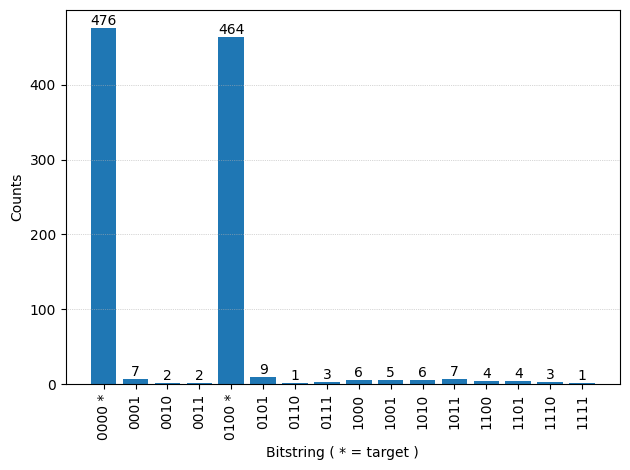

In [35]:
import matplotlib.pyplot as plt

foms = qonscious_result["figures_of_merit_results"]
firstfom = foms[0]
# La impresion quedo rarisima, asi que debe hacerse mejor, cambiar FOM para que tenga un metodo de impresion?
props = firstfom["properties"]
n = props["num_qubits"]
print("Propiedades:", props)
targets = set(props.get("target_states", []) or [])  # ← acá están los targets
# counts = del experimento del FoM (NO del on_pass)
exp = firstfom.get("experiment_result") or {}
counts = exp["counts"] if isinstance(exp, dict) else getattr(exp, "counts", {})
print("n =", n, "counts keys:", sorted(counts.keys())[:10])
labels = [format(i, f'0{n}b') for i in range(2**n)]
values = [counts.get(b, 0) for b in labels]
tick_labels = [lbl + (" *" if lbl in targets else "") for lbl in labels]

fig, ax = plt.subplots()
bars = ax.bar(range(len(labels)), values)
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(tick_labels, rotation=90)
ax.set_ylabel("Counts"); ax.set_xlabel("Bitstring ( * = target )")
ax.grid(True, axis='y', linestyle=':', linewidth=0.5)
for i, bar in enumerate(bars):
    v = values[i]
    if v: ax.text(bar.get_x()+bar.get_width()/2, v, str(v), ha='center', va='bottom')
plt.tight_layout()
plt.show()

